### Preview Data

In [56]:
from fastai.vision.all import *
#hide
from fastbook import *

In [57]:
path = Path("../data/usq/train/images")

In [58]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path)

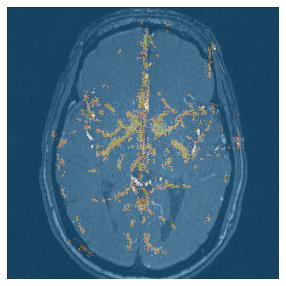

In [59]:
img = PILImage.create(fnames[0])
mask = PILMask.create(str(fnames[0]).replace('images','masks'))
#mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

(-0.5, 319.5, 319.5, -0.5)

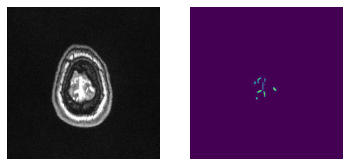

In [77]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(PILImage.create('../data/usq/original_mra/MNI_0590/S580900217.jpg'));
ax[0].axis('off')
ax[1].imshow(PILMask.create('../data/usq/manual_segmentation/MNI_0590/Segmentation0217.jpg'));
ax[1].axis('off')

### Load Data

In [1]:
from fastai.vision.all import *
#hide
from fastbook import *

In [2]:
#path = Path("../data/usq/train/images")
path = Path("../data/usq/imageprojections/all/images")
#path = Path("../data/usq/imageprojections/p9/images")

In [3]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [4]:
codes = ['Background', 'CV']

In [5]:
def get_y(o):
    return get_msk(o)

In [6]:
img_size = (320, 566)

In [7]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   #item_tfms=Resize((320, 247)))#, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   item_tfms=Resize(img_size),#, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])
                   #batch_tfms = [RandomResizedCrop((247, 320)), 
                   #          *aug_transforms(mult=1.0, do_flip=True, 
                   #                          max_rotate=30.0, max_zoom=1.5,
                   #                           max_lighting=.8, max_warp=0.3, 
                   #                          p_lighting=.9)])

In [10]:
dsets = dblock.datasets(path)

dls = dblock.dataloaders(path, bs=1)
#dls = dblock.dataloaders(path, bs=8)
dls.vocab = codes

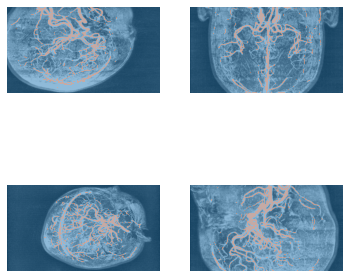

In [9]:
dls.show_batch()

## Modelling

### Dense U-Net

In [11]:
import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

2021-12-03 10:52:26,133 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [12]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
#encoder = efficient_unet(1)
unet = DynamicUnet(encoder, n_classes=2, img_size=(img_size), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)

    sn        layer     c    w    h               size
2    2         ReLU    64  160  283  (1, 64, 160, 283)
8    8  _DenseBlock  1024   20   35  (1, 1024, 20, 35)
11  11  BatchNorm2d  1024   10   17  (1, 1024, 10, 17)


In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Weighted Cross Entropy Loss Function

In [15]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [16]:
weights = torch.tensor([[0.5] + [2.5]]).cuda()
weights

tensor([[0.5000, 2.5000]], device='cuda:0')

In [17]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [18]:
# use customer weighted loss function
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])
learn.summary()

In [43]:
learn = unet_learner(dls, resnet34, Dice(), metrics=[foreground_acc, Dice()])

In [ ]:
## Ranger

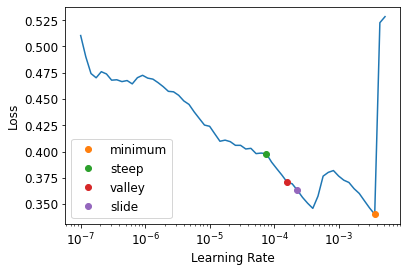

In [14]:
opt = ranger
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()], opt_func=opt)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [15]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.206034,0.143810,0.812608,0.702207,00:49
1,0.177198,0.147708,0.575251,0.644467,00:49
2,0.159420,0.141462,0.616788,0.656366,00:49
3,0.132306,0.123050,0.606839,0.686443,00:49
4,0.113300,0.110480,0.722853,0.742983,00:49
5,0.104454,0.112273,0.655904,0.719194,00:49


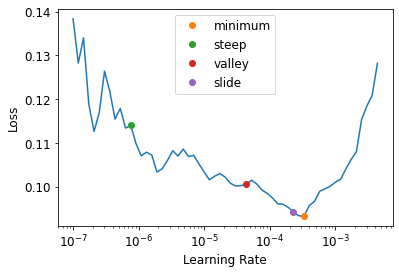

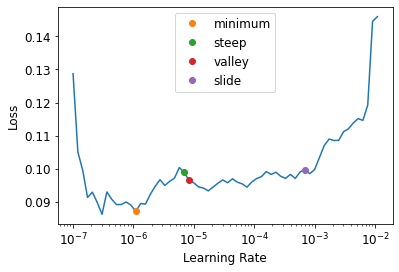

In [16]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
learn.unfreeze()

In [17]:
learn.fit_one_cycle(100, lrs.steep, 
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=5, min_lr=lrs.minimum),
                                         EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=15),
                                         SaveModelCallback(monitor='dice', min_delta=0.01)])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.098239,0.112573,0.654060,0.716040,00:49
1,0.098938,0.113848,0.626808,0.702889,00:49
2,0.097952,0.114222,0.625586,0.700357,00:49
3,0.097224,0.111633,0.669649,0.723785,00:49
4,0.096120,0.112404,0.651431,0.715083,00:49
5,0.098767,0.110436,0.687166,0.734197,00:49
6,0.099176,0.111651,0.660026,0.722522,00:49
7,0.098977,0.109481,0.702368,0.740392,00:49
8,0.097949,0.111203,0.668486,0.725608,00:49
9,0.098660,0.110005,0.686965,0.735590,00:49


Better model found at epoch 0 with dice value: 0.7160401050553074.
Better model found at epoch 5 with dice value: 0.7341968622634135.
Epoch 5: reducing lr to 1.1723800511620494e-07
Epoch 10: reducing lr to 2.968962098428031e-07
Epoch 15: reducing lr to 5.005632560155264e-07
Epoch 20: reducing lr to 6.504452046639488e-07
No improvement since epoch 5: early stopping


In [ ]:
# end ranger

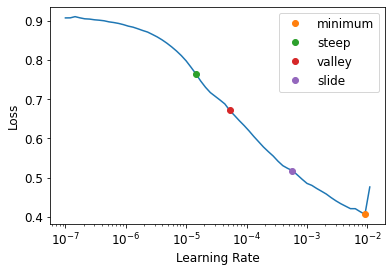

In [41]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [48]:
learn.fit_one_cycle(12, lr_max=1e-5)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.095842,0.106302,0.719515,0.735968,00:05
1,0.096746,0.106365,0.770361,0.748195,00:05
2,0.096771,0.106001,0.704945,0.734057,00:05
3,0.096469,0.106382,0.788435,0.751485,00:05
4,0.096413,0.105351,0.780134,0.752365,00:05
5,0.095860,0.104818,0.733947,0.742602,00:05
6,0.095642,0.106490,0.797917,0.753372,00:05
7,0.095858,0.106720,0.801215,0.753571,00:05
8,0.095432,0.107932,0.661120,0.717081,00:05
9,0.094970,0.104676,0.752885,0.747051,00:05


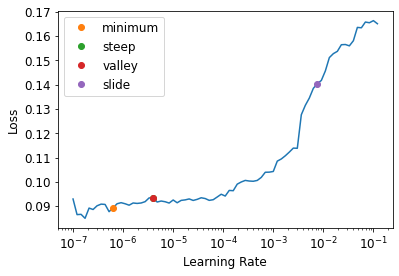

In [49]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [52]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 6.31e-08, steepest point: 3.98e-06


In [55]:
learn.fit_one_cycle(100, lrs.steep, 
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=5, min_lr=lrs.minimum),
                                         EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=15),
                                         SaveModelCallback(monitor='dice', min_delta=0.01)])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.093496,0.104947,0.729191,0.741163,00:05
1,0.092973,0.104661,0.737292,0.743288,00:05
2,0.092310,0.104764,0.735683,0.742884,00:05
3,0.092796,0.104917,0.730115,0.741163,00:05
4,0.092782,0.104990,0.749338,0.745893,00:05
5,0.092267,0.105161,0.737631,0.743081,00:05
6,0.092867,0.105241,0.722771,0.739215,00:05
7,0.092418,0.105004,0.750289,0.746211,00:05
8,0.092083,0.104888,0.733530,0.742358,00:05
9,0.092670,0.104786,0.754688,0.747367,00:05


Better model found at epoch 0 with dice value: 0.7411628722749674.
Epoch 5: reducing lr to 6.669297835116612e-08
Epoch 10: reducing lr to 1.6973563267041294e-07
Epoch 15: reducing lr to 2.870180064799527e-07
No improvement since epoch 0: early stopping


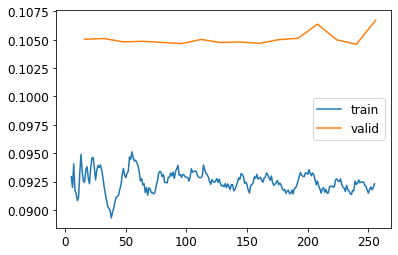

In [54]:
learn.recorder.plot_loss()

## Results

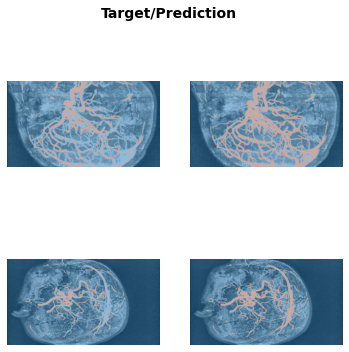

In [28]:
learn.show_results()

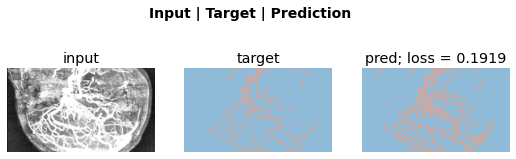

In [29]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=1)

### Save model

In [30]:
#export model as pickle
#learn.export('dense_unet_mip_images_model.pkl')
learn.save('dense_unet_mip_images_model_p9')

Path('models/dense_unet_mip_images_model_p9.pth')

In [18]:
learn.export('dense_unet_mip_images_model_p999')